In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [367]:
# import ML tools
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (RandomizedSearchCV, train_test_split, 
                                     cross_val_score, validation_curve)
from sklearn.metrics import r2_score, mean_squared_error
import pickle
import time
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [3]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


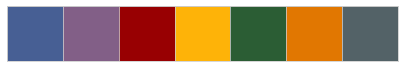

In [4]:
# import custom palette
import my_palette as mp

In [5]:
# read in actor dataset
df = pd.read_json('capstone1_ds.json')

> **GIVEN TARGET**

I will start with analyzing the unmodified dataset.

In [6]:
# observe dimensionality of dataset
df.shape

(11693, 28)

There are 27 independent variables.

In [7]:
# observe feature names
df.columns

Index(['actor_value', 'budget', 'age', 'gender', 'order', 'popularity',
       'release_date', 'runtime', 'usa', 'vote_average', 'vote_count',
       'action', 'adventure', 'animation', 'comedy', 'crime', 'drama',
       'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'romance',
       'science_fiction', 'thriller', 'war', 'western'],
      dtype='object')

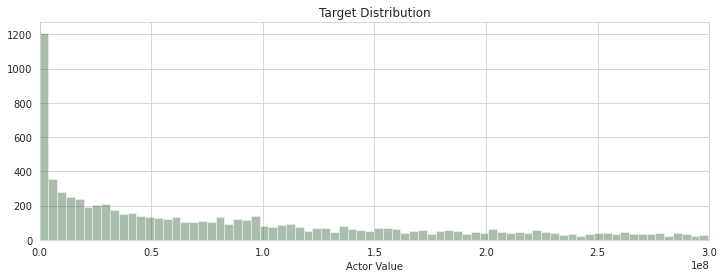

In [8]:
# plot target distribution up to $300,000,000

plt.xlim(0, 3e8)

sns.distplot(df['actor_value'], bins=5000, color=mp.colors(4), 
             axlabel='Actor Value', kde=False)

plt.title('Target Distribution');

In [9]:
# separate data into features and target for given target
X = df.drop('actor_value', axis=1)
y = df['actor_value']

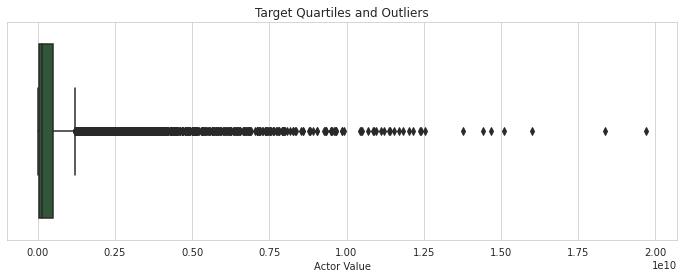

In [10]:
# plot target quartiles and outliers

sns.boxplot(y, color=mp.colors(4))

plt.xlabel('Actor Value')
plt.title('Target Quartiles and Outliers');

In [11]:
# get statistics for target
y.describe()

count    1.169300e+04
mean     5.647359e+08
std      1.243346e+09
min      1.238841e+00
25%      3.130126e+07
50%      1.396449e+08
75%      5.060413e+08
max      1.970652e+10
Name: actor_value, dtype: float64

First, I will split the data to create a holdout set for validation.

In [12]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

I will observe the out of the box Random Forest Regressor model.

In [335]:
def get_base_model(features, target):
    """Return base random forest regressor model"""
    model = RandomForestRegressor(random_state=27, warm_start=True)
    model.fit(features, target)
    
    return model

In [336]:
def get_params(model):
    """Return hyperparameters of interest from regressor"""
    series = pd.Series(
        model.get_params(), name='model_params').drop(
        ['bootstrap', 'ccp_alpha', 'criterion', 'max_leaf_nodes', 'max_samples', 
        'min_impurity_decrease', 'min_impurity_split', 'min_weight_fraction_leaf', 
        'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
    
    return series

In [337]:
# instantiate base model for given target and get parameters
base_model = get_base_model(X_train, y_train)
get_params(base_model)

max_depth            None
max_features         auto
min_samples_leaf        1
min_samples_split       2
n_estimators          100
Name: model_params, dtype: object

In [338]:
def get_cv_adj_r2(features, target, model):
    """Return cross-validation average adjusted R2 score and adjusted R2 score range"""
    cv_results = cross_val_score(model, features, target, cv=10, n_jobs=-1)
    
    n = features.shape[0]
    p = features.shape[1]
    adj_r2 = 1 - (1 - cv_results) * ((n - 1)  / (n - p - 1))

    # get range of scores
    results_range = (np.min(adj_r2), np.max(adj_r2))
    # get average score and round to 5 decimal places
    ave_result = np.mean(adj_r2)

    return f'Average Adjusted R2 Score: {ave_result:.4f}, Range: {results_range[0]:.4f}, {results_range[1]:.4f}'

In [339]:
# get statistics for 10 fold cross-validation
get_cv_adj_r2(X_train, y_train, base_model)

'Average Adjusted R2 Score: 0.9020, Range: 0.8554, 0.9310'

In [18]:
def get_cv_rmse(features, target, model):
    """Return CV average root mean squared error and root mean square error range"""
    cv_results = cross_val_score(model, features, target, 
                                 scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
#    global results
    results = np.round(np.sqrt(cv_results * -1), 5)
    results_range = (np.min(results), np.max(results))
    ave_result = np.round(np.sqrt(np.mean(cv_results) * -1), 5)
        
    return f'Average RMSE: ${ave_result:,.2f}, Range: (${results_range[0]:,.2f}, ${results_range[1]:,.2f})'

In [19]:
# get cross-validation results
get_cv_rmse(X_train, y_train, base_model)

'Average RMSE: $383,013,617.61, Range: ($313,610,010.68, $492,679,198.76)'

In [20]:
def plot_predictions(features, target, model):
    """Return plot of observed target vs. predictions"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)

    sns.scatterplot(y_test, model.predict(X_test), color=mp.colors(1))
    sns.regplot(y_test, model.predict(X_test), color=mp.colors(6), scatter=False)
    
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    plt.title("Ground Truth vs Predicted");

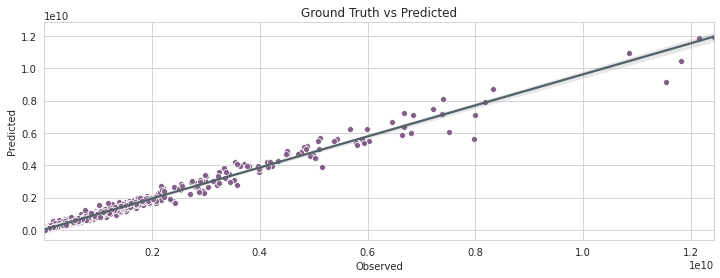

In [354]:
# plot observed target vs. predictions for out of the box rfr model
plot_predictions(X_train, y_train, base_model)

In [22]:
def plot_residuals(features, target, model):
    """Return plot of predictions vs.residuals"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)

    sns.residplot(
        model.predict(X_test), y_test, lowess=True, scatter_kws={'s':10}, 
        color=mp.colors(2), line_kws={'linewidth':3})
    
    plt.xlabel('Predicted Actor Value')
    plt.ylabel('Residuals')
    
    plt.title("Predicted vs Residuals");

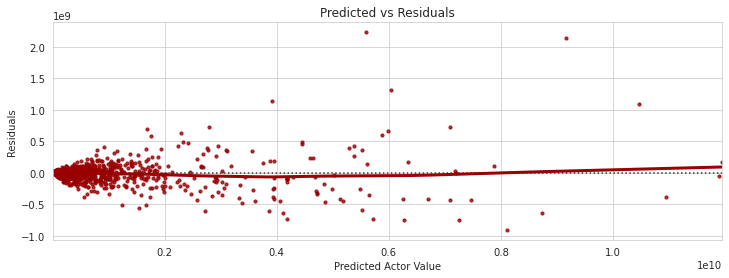

In [353]:
# plot predictions vs. residuals for out of the box rfr model
plot_residuals(X_train, y_train, base_model)

In [350]:
def plot_residual_distribution(features, target, model):
    """Return plot of distribution of residuals"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    
    sns.distplot(
        (y_test - model.predict(X_test)), bins=300, rug=True, axlabel='Residuals', 
        color=mp.colors(4))

    plt.ylabel('Frequency')

    plt.title('Distribution of Residuals');

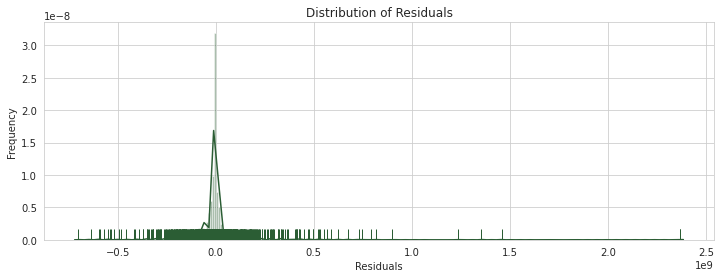

In [352]:
# plot residuals distribution for out of the box rfr model
plot_residual_distribution(X_train, y_train, base_model)

In [361]:
# create initial parameter search grid
param_grid_1 = {
    'max_depth': [int(x) for x in np.linspace(1, 10, num=10)] + [None],
    'max_features': [int(x) for x in np.linspace(1, 15, num=15)],
    'min_samples_leaf': [int(x) for x in np.linspace(1, 70, num=15)],
    'min_samples_split': [int(x) for x in np.linspace(2, 100, num=11)],
    'n_estimators': [int(x) for x in np.linspace(5, 100, num=20)]
}
for param, param_lst in param_grid_1.items():
    print(param, param_lst)

max_depth [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
max_features [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
min_samples_leaf [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
min_samples_split [2, 11, 21, 31, 41, 51, 60, 70, 80, 90, 100]
n_estimators [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


In [362]:
def plot_hp(train_scores, test_scores, param_lst):
    # get scores stats
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    # plot training scores
    sns.lineplot(x=param_lst, y=train_scores_mean, label="Training Score",
                 color=mp.colors(5), lw=2)
    plt.fill_between(param_lst, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color=mp.colors(5), lw=2)
    # plot test scores
    sns.lineplot(x=param_lst, y=test_scores_mean, label="Test Score",
                 color=mp.colors(0), lw=2)
    plt.fill_between(param_lst, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color=mp.colors(0), lw=2)
    plt.ylabel("RMSE", fontsize=15)
    plt.legend(bbox_to_anchor=(1.2, 0.5), loc=5, fontsize='large')

In [344]:
def plot_hyperparameters(features, target, model, grid):
    """Plots CV results for each hyperparameter"""
    count = 0
    n_hp = len(grid.items())
    fig, axes = plt.subplots(nrows=n_hp, figsize=(12, 12))
    for param, param_lst in grid.items():
        # get CV scores
        train_scores, test_scores = validation_curve(
            model, features, target, param_name=param, param_range=param_lst, 
            cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
        # convert scores to root-mean-square error
        train_rmse = np.sqrt(train_scores * -1)
        test_rmse = np.sqrt(test_scores * -1)
        # replace None value in max depth with dummy numeric to plot
        if param == 'max_depth':
            param_lst = param_lst[:-1]
            param_lst.append(param_lst[0] + param_lst[-1])
        count += 1
        plt.subplot(n_hp, 1, count)
        plt.xlim(np.min(param_lst), np.max(param_lst))
        plot_hp(train_rmse, test_rmse, param_lst)
        plt.xlabel(param, fontsize=15)  
    plt.suptitle("Validation Curves with RFR", y=1.04, fontsize=20)
    plt.tight_layout();

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of 110 | elapsed:   10.7s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   18.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of 150 | elapsed:   12.9s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   22.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of 150 | elapsed:   17.9s remaining:   17.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   32.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  55 out of 110 | elapsed:   17.7s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   29.5s finished
[Pa

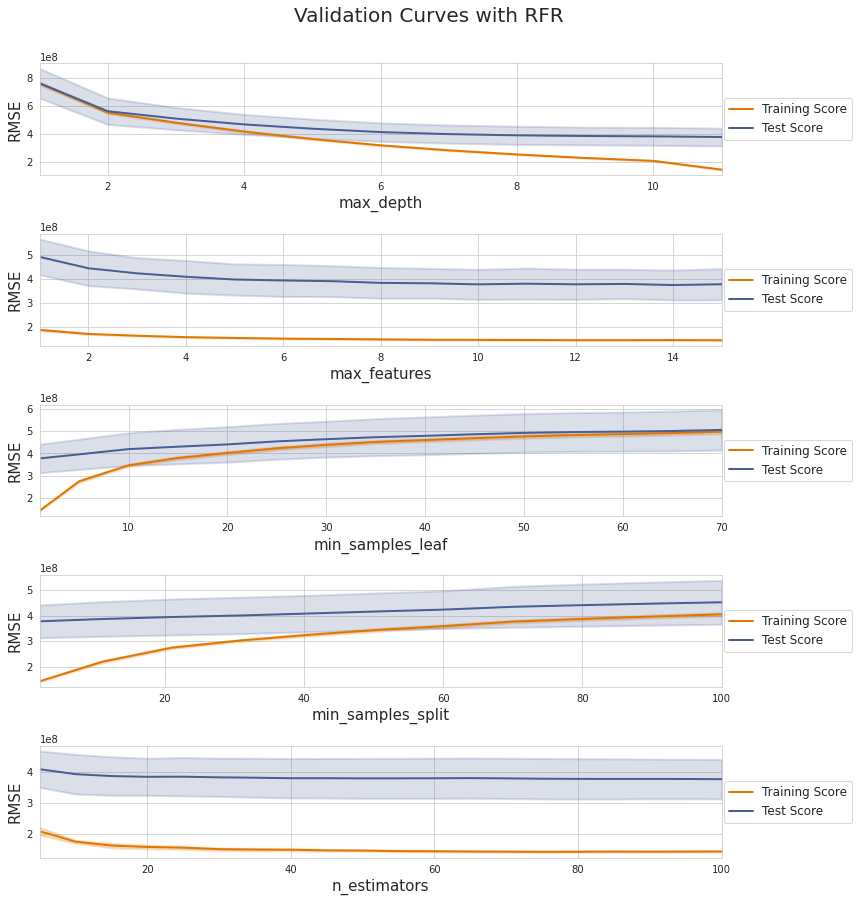

In [363]:
plot_hyperparameters(X_train, y_train, base_model, param_grid_1)

> **BAYESIAN HYPERPARAMETER SEARCH**

In [364]:
# create search grid
hp_space_1 = {'max_depth': hp.quniform('max_depth', 2, 8, 1), 
        'max_features': hp.quniform('max_features', 8, 11, 1), 
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 70, 1), 
        'min_samples_split': hp.quniform('min_samples_split', 2, 100, 1), 
        'n_estimators': hp.quniform('n_estimators', 5, 100, 5)}

In [371]:
def objective(params):
    params = {'max_depth': int(params['max_depth']), 
             'max_features': int(params['max_features']), 
             'min_samples_leaf': int(params['min_samples_leaf']), 
             'min_samples_split': int(params['min_samples_split']), 
             'n_estimators': int(params['n_estimators'])}
    rfr = RandomForestRegressor(**params)
    results = cross_val_score(rfr, X_train, y_train, scoring='neg_mean_squared_error', 
                                 cv=10, n_jobs=-1).mean()
    best_score = np.sqrt(results * -1)

    return {'loss': best_score, 
           'status': STATUS_OK}

In [372]:
trials = Trials()

In [373]:
best_result_1 = fmin(fn=objective, space=hp_space_1, max_evals=100, trials=trials, 
                   rstate=np.random.RandomState(27), algo=tpe.suggest)

100%|██████████| 100/100 [00:44<00:00,  2.27trial/s, best loss: 423319767.828209] 


In [376]:
pickle.dump(trials, open('my_trials.pkl', 'wb'))

In [377]:
trials = pickle.load(open('my_trials.pkl', 'rb'))

In [378]:
print(best_result_1)

{'max_depth': 8.0, 'max_features': 10.0, 'min_samples_leaf': 1.0, 'min_samples_split': 26.0, 'n_estimators': 30.0}


In [379]:
best_result_1 = fmin(fn=objective, space=hp_space_1, max_evals=200, trials=trials, 
                   rstate=np.random.RandomState(27), algo=tpe.suggest)

100%|██████████| 200/200 [01:19<00:00,  2.53trial/s, best loss: 405867047.6096916] 


In [380]:
print(best_result_1)

{'max_depth': 8.0, 'max_features': 10.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 90.0}


In [381]:
pickle.dump(trials, open('my_trials.pkl', 'wb'))

In [382]:
trials = pickle.load(open('my_trials.pkl', 'rb'))

In [383]:
best_result_1 = fmin(fn=objective, space=hp_space_1, max_evals=300, trials=trials, 
                   rstate=np.random.RandomState(27), algo=tpe.suggest)

100%|██████████| 300/300 [01:35<00:00,  3.16trial/s, best loss: 401901898.19767135]


In [384]:
print(best_result_1)

{'max_depth': 8.0, 'max_features': 10.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 90.0}


In [385]:
pickle.dump(trials, open('my_trials.pkl', 'wb'))

In [386]:
trials = pickle.load(open('my_trials.pkl', 'rb'))

In [387]:
best_result_1 = fmin(fn=objective, space=hp_space_1, max_evals=400, trials=trials, 
                   rstate=np.random.RandomState(27), algo=tpe.suggest)

100%|██████████| 400/400 [01:37<00:00,  4.10trial/s, best loss: 400252761.9364011] 


In [390]:
print(best_result_1)

{'max_depth': 8.0, 'max_features': 11.0, 'min_samples_leaf': 1.0, 'min_samples_split': 4.0, 'n_estimators': 95.0}


In [391]:
pickle.dump(trials, open('my_trials.pkl', 'wb'))

In [392]:
trials = pickle.load(open('my_trials.pkl', 'rb'))

In [393]:
best_result_1 = fmin(fn=objective, space=hp_space_1, max_evals=500, trials=trials, 
                   rstate=np.random.RandomState(27), algo=tpe.suggest)

100%|██████████| 500/500 [01:44<00:00,  4.78trial/s, best loss: 399435247.3361009]


In [394]:
print(best_result_1)

{'max_depth': 8.0, 'max_features': 11.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 85.0}


In [395]:
pickle.dump(trials, open('my_trials.pkl', 'wb'))

In [396]:
trials = pickle.load(open('my_trials.pkl', 'rb'))

In [398]:
best_result_1 = fmin(fn=objective, space=hp_space_1, max_evals=600, trials=trials, 
                   rstate=np.random.RandomState(27), algo=tpe.suggest)

100%|██████████| 600/600 [01:37<00:00,  6.15trial/s, best loss: 399435247.3361009]


In [399]:
print(best_result_1)

{'max_depth': 8.0, 'max_features': 11.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 85.0}


In [400]:
pickle.dump(trials, open('my_trials.pkl', 'wb'))

In [401]:
trials = pickle.load(open('my_trials.pkl', 'rb'))

In [402]:
best_result_1 = fmin(fn=objective, space=hp_space_1, max_evals=700, trials=trials, 
                   rstate=np.random.RandomState(27), algo=tpe.suggest)

100%|██████████| 700/700 [01:46<00:00,  6.56trial/s, best loss: 399435247.3361009]


In [403]:
print(best_result_1)

{'max_depth': 8.0, 'max_features': 11.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 85.0}


In [404]:
pickle.dump(trials, open('my_trials.pkl', 'wb'))

In [405]:
trials = pickle.load(open('my_trials.pkl', 'rb'))

In [406]:
best_result_1 = fmin(fn=objective, space=hp_space_1, max_evals=800, trials=trials, 
                   rstate=np.random.RandomState(27), algo=tpe.suggest)

100%|██████████| 800/800 [01:47<00:00,  7.44trial/s, best loss: 399435247.3361009]


In [407]:
print(best_result_1)

{'max_depth': 8.0, 'max_features': 11.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 85.0}


In [408]:
pickle.dump(trials, open('my_trials.pkl', 'wb'))

In [409]:
trials = pickle.load(open('my_trials.pkl', 'rb'))

In [410]:
best_result_1 = fmin(fn=objective, space=hp_space_1, max_evals=900, trials=trials, 
                   rstate=np.random.RandomState(27), algo=tpe.suggest)

100%|██████████| 900/900 [01:51<00:00,  8.06trial/s, best loss: 399435247.3361009]


In [411]:
print(best_result_1)

{'max_depth': 8.0, 'max_features': 11.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 85.0}


In [412]:
pickle.dump(trials, open('my_trials.pkl', 'wb'))

In [413]:
trials = pickle.load(open('my_trials.pkl', 'rb'))

In [414]:
best_result_1 = fmin(fn=objective, space=hp_space_1, max_evals=1000, trials=trials, 
                   rstate=np.random.RandomState(27), algo=tpe.suggest)

100%|██████████| 1000/1000 [01:52<00:00,  8.86trial/s, best loss: 399435247.3361009]


In [415]:
print(best_result_1)

{'max_depth': 8.0, 'max_features': 11.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 85.0}


> **RANDOM GRID SEARCH**

I will use a random grid search to tune the hyperparameters.

In [26]:
# create initial parameter search grid
random_grid_1 = {
    'max_depth': [int(x) for x in np.linspace(10, 100, num=10)] + [None],
    'max_features': [int(x) for x in np.linspace(1, 10, num=10)],
    'min_samples_leaf': [int(x) for x in np.linspace(1, 10, num=10)],
    'min_samples_split': [int(x) for x in np.linspace(1, 10, num=10)],
    'n_estimators': [int(x) for x in np.linspace(600, 2400, num=10)]}
random_grid_1

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'n_estimators': [600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400]}

In [27]:
def get_best_model(train_features, train_target, grid):
    """Return best model for randomized hyperparameter grid search"""
    # instantiate model
    rfr = RandomForestRegressor(random_state=27)
    # instantiate grid search model
    rfr_random = RandomizedSearchCV(
        estimator=rfr, param_distributions=grid, n_iter=100, cv=3, 
        scoring='neg_root_mean_squared_error', verbose=1, 
        random_state=27, n_jobs=-1, return_train_score=True)
    # fit search model
    rfr_random.fit(train_features, train_target)
    # get best model
    best_model = rfr_random.best_estimator_
    # get cross-validation results
    results_df = pd.DataFrame(
        rfr_random.cv_results_).set_index(
        'rank_test_score', drop=True).sort_index()
    
    return best_model, results_df

In [28]:
# get 1st best model and results
best_model_1, results_1 = get_best_model(X_train, y_train, random_grid_1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.5min finished


In [29]:
# get parameters
get_params(best_model_1)

max_depth            None
max_features            9
min_samples_leaf        1
min_samples_split       5
n_estimators         2000
Name: full_target, dtype: object

In [30]:
# get statistics for 10 fold cross-validation
get_cv_adj_r2(X_train, y_train, best_model_1)

'Average Adjusted R2 Score: 0.8990, Range: 0.8494, 0.9324'

In [31]:
# get statistics for 10 fold cross-validation
get_cv_rmse(X_train, y_train, best_model_1)

'Average RMSE: $388,652,683.43, Range: ($316,341,108.15, $502,724,734.60)'

In [32]:
def get_results(results):
    # remove annoying prefix
    new_cols = [i[i.startswith('param_') and len('param_'):] 
                for i 
                in results.columns.to_list()]
    my_results = results.rename(dict(zip(results.columns, new_cols)), axis=1)
    # rename index
    my_results.index.names = ['rank']
    # set columns to return
    slices = [13, 18, 8, 7, 6, 5, 4]
    
    return my_results.head(15).iloc[:, slices]

In [33]:
# get grid results
get_results(results_1)

,mean_test_score,mean_train_score,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
rank,,,,,,,
1,-4.017601e+08,-1.876261e+08,None,9,1,5,2000
2,-4.080722e+08,-1.655386e+08,80,7,1,3,1800
3,-4.087273e+08,-2.249722e+08,50,8,1,8,1000
4,-4.095158e+08,-2.238470e+08,100,9,2,5,1800
5,-4.126190e+08,-2.563123e+08,20,10,3,6,600
6,-4.133193e+08,-2.283528e+08,40,8,2,5,2400
7,-4.141237e+08,-2.305967e+08,70,7,1,8,1800
8,-4.151296e+08,-2.399869e+08,100,7,1,9,1600
9,-4.179562e+08,-2.902030e+08,40,10,4,5,2400


In [43]:
def plot_results_param(parameter, results):
    """Returns plot of test scores for random parameter"""
    sns.scatterplot(results['param_' + parameter], 
             results['mean_test_score'] * -1, label='Test', color=mp.colors(4))

    plt.xlabel(parameter)
    plt.ylabel('Root Mean Squared Error')
    plt.legend()
    plt.title('Average Train and Test Scores');

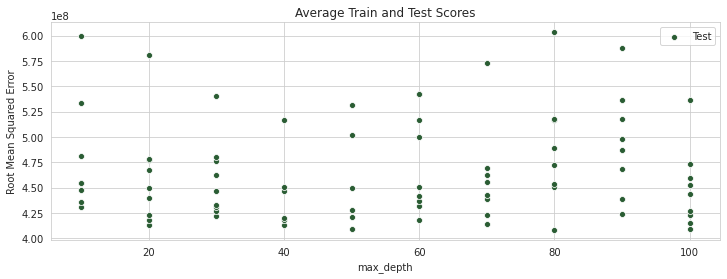

In [44]:
plot_results_param('max_depth', results_1)

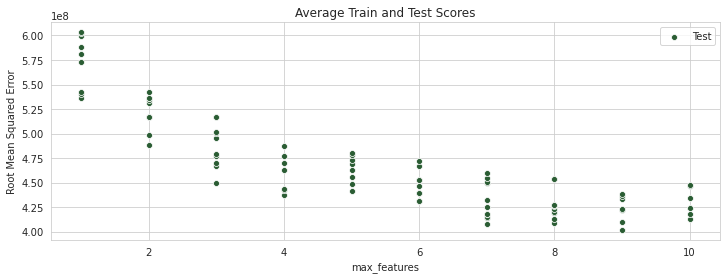

In [48]:
plot_results_param('max_features', results_1)

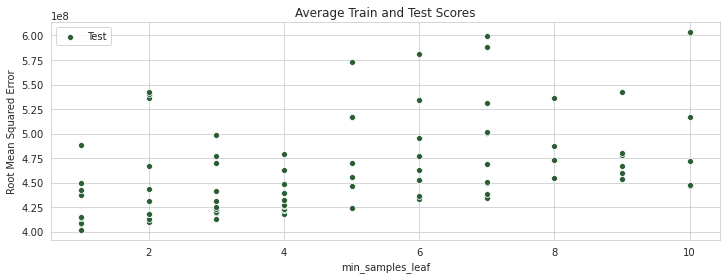

In [45]:
plot_results_param('min_samples_leaf', results_1)

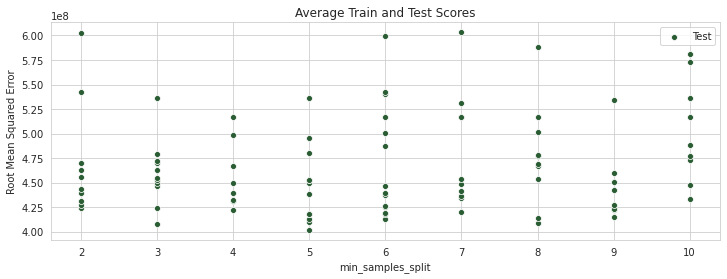

In [46]:
plot_results_param('min_samples_split', results_1)

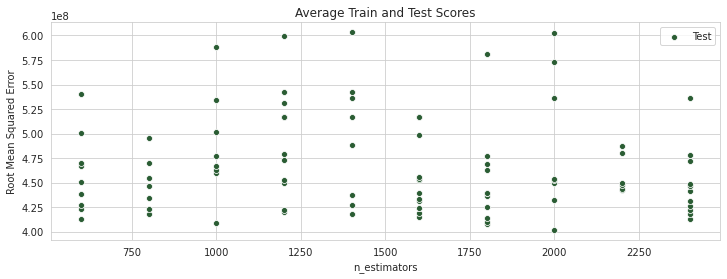

In [47]:
plot_results_param('n_estimators', results_1)

In [69]:
# create initial parameter search grid
random_grid_2 = {
    'max_depth': [int(x) for x in np.linspace(30, 60, num=10)] + [None],
    'max_features': [int(x) for x in np.linspace(8, 17, num=10)],
    'min_samples_leaf': [int(x) for x in np.linspace(1, 5, num=5)],
    'min_samples_split': [int(x) for x in np.linspace(1, 5, num=5)],
    'n_estimators': [int(x) for x in np.linspace(400, 3000, num=14)]}
random_grid_2

{'max_depth': [30, 33, 36, 40, 43, 46, 50, 53, 56, 60, None],
 'max_features': [8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 'min_samples_leaf': [1, 2, 3, 4, 5],
 'min_samples_split': [1, 2, 3, 4, 5],
 'n_estimators': [400,
  600,
  800,
  1000,
  1200,
  1400,
  1600,
  1800,
  2000,
  2200,
  2400,
  2600,
  2800,
  3000]}

In [70]:
# get next best model and results
best_model_2, results_2 = get_best_model(X_train, y_train, random_grid_2)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.3min finished


In [72]:
# get parameters
get_params(best_model_2)

max_depth              60
max_features           16
min_samples_leaf        1
min_samples_split       4
n_estimators         1200
Name: full_target, dtype: object

In [73]:
# get statistics for 10 fold cross-validation
get_cv_adj_r2(X_train, y_train, best_model_2)

'Average Adjusted R2 Score: 0.9028, Range: 0.8564, 0.9332'

In [74]:
# get statistics for 10 fold cross-validation
get_cv_rmse(X_train, y_train, best_model_2)

'Average RMSE: $381,340,762.54, Range: ($310,573,083.72, $490,938,798.09)'

In [75]:
# get grid results
get_results(results_2)

,mean_test_score,mean_train_score,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
rank,,,,,,,
1,-3.924470e+08,-1.681064e+08,60,16,1,4,1200
2,-3.925810e+08,-1.572629e+08,50,14,1,3,1200
3,-3.927085e+08,-1.684097e+08,30,16,1,4,1400
4,-3.927270e+08,-1.681335e+08,36,15,1,4,2000
5,-3.927884e+08,-1.466250e+08,36,14,1,2,400
6,-3.934137e+08,-1.688080e+08,None,14,1,4,1800
7,-3.935848e+08,-1.688059e+08,43,14,1,4,2200
8,-3.937091e+08,-1.691321e+08,40,13,1,4,400
9,-3.945319e+08,-1.812291e+08,30,13,1,5,2000


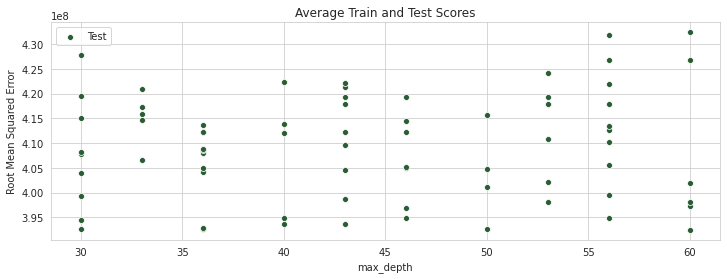

In [76]:
plot_results_param('max_depth', results_2)

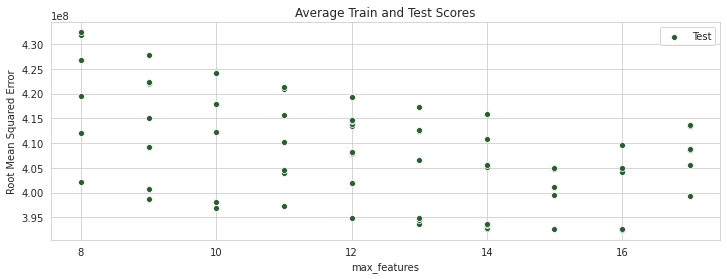

In [77]:
plot_results_param('max_features', results_2)

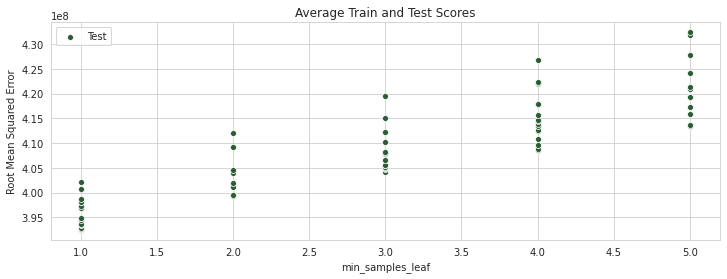

In [78]:
plot_results_param('min_samples_leaf', results_2)

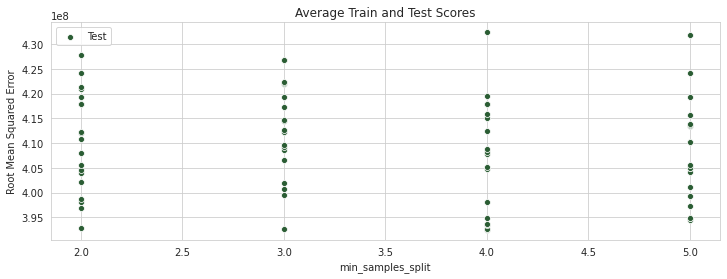

In [79]:
plot_results_param('min_samples_split', results_2)

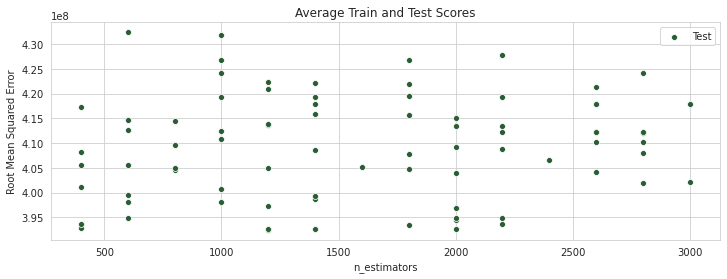

In [80]:
plot_results_param('n_estimators', results_2)

In [91]:
# create initial parameter search grid
random_grid_3 = {
    'max_depth': [int(x) for x in np.linspace(1, 100, num=100)] + [None],
    'max_features': [int(x) for x in np.linspace(1, 20, num=20)],
    'min_samples_leaf': [int(x) for x in np.linspace(1, 10, num=10)],
    'min_samples_split': [int(x) for x in np.linspace(1, 20, num=20)],
    'n_estimators': [int(x) for x in np.linspace(400, 3000, num=14)]}
print(random_grid_3)

{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, None], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'n_estimators': [400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000]}


In [92]:
# set to use 300 models
def get_best_model(train_features, train_target, grid):
    """Return best model for randomized hyperparameter grid search"""
    # instantiate model
    rfr = RandomForestRegressor(random_state=27)
    # instantiate grid search model
    rfr_random = RandomizedSearchCV(
        estimator=rfr, param_distributions=grid, n_iter=300, cv=3, 
        scoring='neg_root_mean_squared_error', verbose=1, 
        random_state=27, n_jobs=-1, return_train_score=True)
    # fit search model
    rfr_random.fit(train_features, train_target)
    # get best model
    best_model = rfr_random.best_estimator_
    # get cross-validation results
    results_df = pd.DataFrame(
        rfr_random.cv_results_).set_index(
        'rank_test_score', drop=True).sort_index()
    
    return best_model, results_df

In [93]:
# get next best model and results
best_model_3, results_3 = get_best_model(X_train, y_train, random_grid_3)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 20.9min finished


In [94]:
# get parameters
get_params(best_model_3)

max_depth              80
max_features           20
min_samples_leaf        1
min_samples_split       5
n_estimators         2200
Name: full_target, dtype: object

In [95]:
# get statistics for 10 fold cross-validation
get_cv_adj_r2(X_train, y_train, best_model_3)

'Average Adjusted R2 Score: 0.9020, Range: 0.8544, 0.9306'

In [96]:
# get statistics for 10 fold cross-validation
get_cv_rmse(X_train, y_train, best_model_3)

'Average RMSE: $382,913,227.19, Range: ($310,802,556.14, $494,325,730.06)'

In [97]:
# get grid results
get_results(results_3)

,mean_test_score,mean_train_score,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
rank,,,,,,,
1,-3.935352e+08,-1.782091e+08,80,20,1,5,2200
2,-3.952660e+08,-1.988506e+08,40,17,1,7,3000
3,-3.954080e+08,-1.988564e+08,66,17,1,7,2600
4,-3.968797e+08,-2.146335e+08,47,20,1,9,1400
5,-3.970448e+08,-2.183969e+08,15,18,1,9,2600
6,-3.984611e+08,-1.975819e+08,70,19,2,3,1800
7,-3.987330e+08,-1.960586e+08,61,20,2,2,600
8,-3.992812e+08,-1.993018e+08,85,17,2,2,1800
9,-3.995086e+08,-1.989327e+08,67,17,2,3,800


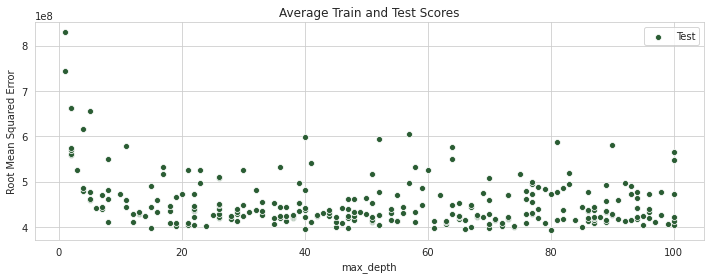

In [98]:
plot_results_param('max_depth', results_3)

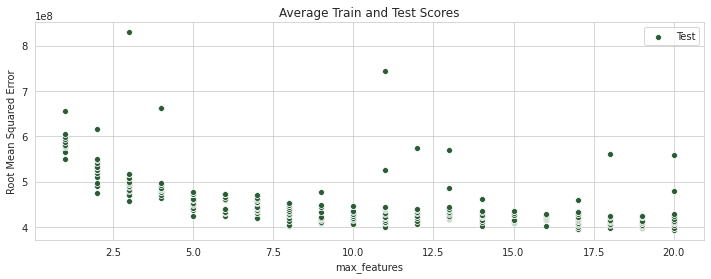

In [99]:
plot_results_param('max_features', results_3)

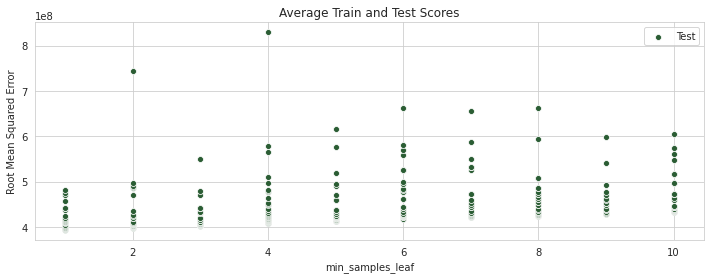

In [100]:
plot_results_param('min_samples_leaf', results_3)

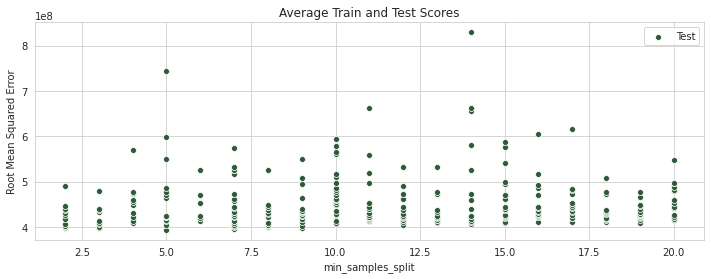

In [101]:
plot_results_param('min_samples_split', results_3)

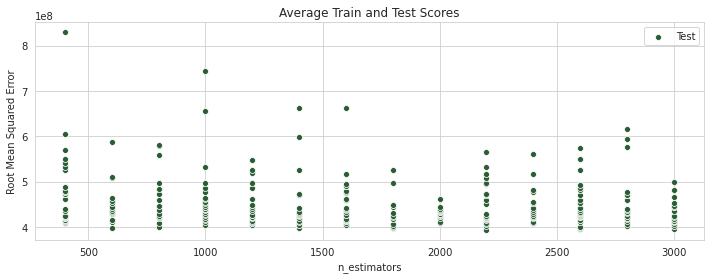

In [102]:
plot_results_param('n_estimators', results_3)

In [388]:
def get_cv_gap(features, target, model):
    """Return CV average generalization gap and generalization gap range"""
    cv_results = cross_validate(model, features, target, 
                            scoring='neg_mean_squared_error', 
                            return_train_score=True, cv=10, n_jobs=-1)
    rmse_train = np.sqrt(cv_results['train_score'] * -1)
    rmse_test = np.sqrt(cv_results['test_score'] * -1)  
#    global results    
    results = rmse_test - rmse_train
    results_range = (np.min(results), np.max(results))
    ave_result = np.mean(results)
        
    return f'Average OE: ${ave_result:,.2f}, Range: (${results_range[0]:,.2f}, ${results_range[1]:,.2f})'

In [389]:
# get cross-validation results
get_cv_gap(X_train, y_train, base_model)

'Average OE: $233,148,885.55, Range: ($166,793,020.92, $351,698,631.83)'